In [2]:
#Code to generate Fig 6 barplots, and full performance scatterplots + AUC curves
from performance_figure_functions import *
from predictor_comparisons import *
from general_funcs import *


In [3]:

def strip_clashing(x, chain):
    if x != 'select clashing_res, ':
        chains_list = re.findall(r'\((.*?)\)',x)
        #print (chains_list)
        for chain_curr in chains_list:
            if chain == 'A' and 'A' in chain_curr:
                return len(chain_curr.split(' ')[-1].split(","))
            elif chain == 'B' and 'B' in chain_curr:
                return len(chain_curr.split(' ')[-1].split(","))
            else:
                return -1
    else:
        return 0
    

def plot_regression(df, savename, w =4, h =2, lim = 1 ):#, c_scheme = 'copper'):
    fig, ax = plt.subplots()#(2,1, sharex= True) #plot AUCROC, MCC, n_features
    # the size of A4 paper
    fig.set_size_inches(w,h)
    
    plt.xlabel('')
    #plotting baseline AUCROC for imbalanced class +
    s =sns.barplot(data = df,
                x = 'dataset', 
                y = 'test_spearman', )
    #s._legend.remove()
    ax.set_ylim(0,lim)
    plt.legend([],[], frameon=False)
    plt.xlabel('')
    
    plt.xticks(rotation=90)
    plt.legend([],[], frameon=False)
    plt.xlabel('')
    
    plt.savefig(savename, dpi = 300)
    plt.show()

def plot_classif(df, savename, w =4, h =2 ):#, c_scheme = 'copper'):
    fig, ax = plt.subplots()

    fig.set_size_inches(w,h)
    
    plt.xlabel('')
    s =sns.barplot(data = df,
                x = 'dataset', 
                y = 'avgpr_test', )
    #s._legend.remove()
    ax.set_ylim(0,1)
    plt.legend([],[], frameon=False)
    plt.xlabel('')
    
    plt.xticks(rotation=90)
    plt.legend([],[], frameon=False)
    plt.xlabel('')
    
    plt.savefig(savename, dpi = 300)
    plt.show()
    

In [4]:
#setup bar graph dataframes
df_reg_bar = pd.DataFrame({'dataset':[], 'test_spearman':[]})
df_reg_bar_malb = pd.DataFrame({'dataset':[], 'test_spearman':[]})
df_class_bar = pd.DataFrame({'dataset':[], 'avgpr_test':[]})

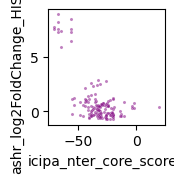

0.39549227725019054


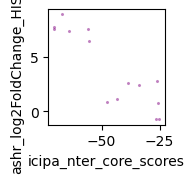

0.8382843356464625 (14, 7)


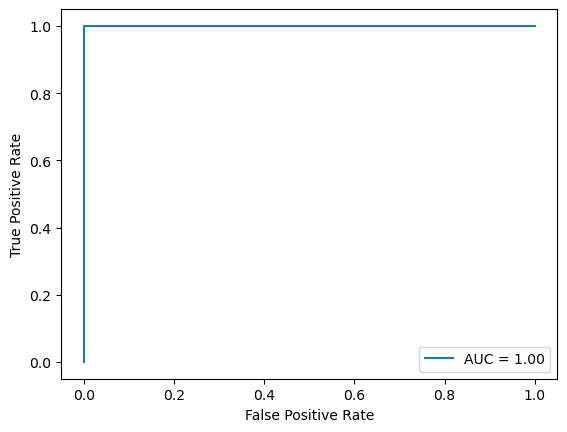

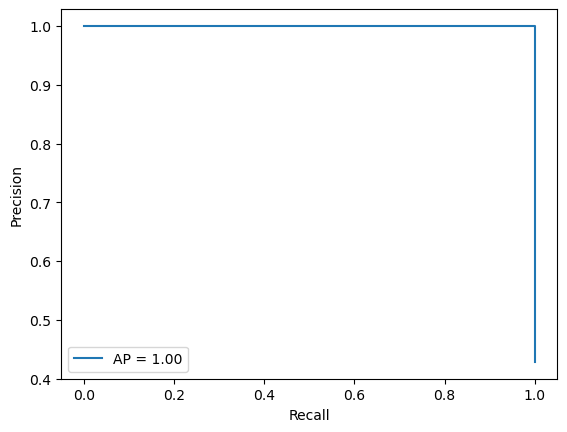

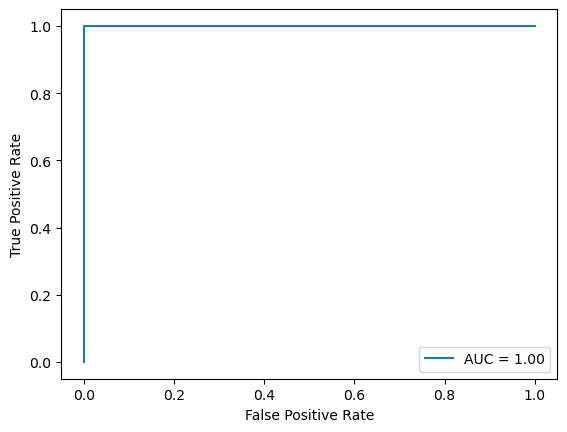

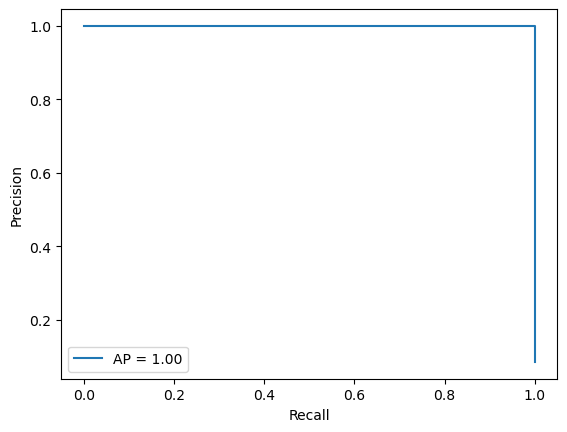

In [5]:
#making icipa scatterplot, AUCROC, AUCPRC

icipa_nter_core_scores = load('PNIC_icipa_nter_core.bin')
   
d=load_score_file("PNIC-complete.out")
ids = sorted(d.ids(), key=natural_key)
mat = symdict_to_array(d, ids)

mp3_seq_values = pd.read_csv('../processing_pipeline/merged_replicates/deseq_jerala_flat_autotune_5_small.csv')
mp3_seq_values = mp3_seq_values.rename(columns = {'Unnamed: 0': 'PPI'})

mp3_seq_values['P1'] = mp3_seq_values.PPI.apply(lambda x: x.split(':')[1])
mp3_seq_values['P2'] = mp3_seq_values.PPI.apply(lambda x: x.split(':')[3])

test_train_split = ['test', 'train'] * int((0.1 * mp3_seq_values.shape[0]))
test_train_split = test_train_split + ['train'] * int(mp3_seq_values.shape[0] - len(test_train_split))
mp3_seq_values = mp3_seq_values.sort_values('ashr_padj_HIS_TRP')
mp3_seq_values['order_padj_sets'] = test_train_split
mp3_seq_values['binned'] = mp3_seq_values.ashr_log2FoldChange_HIS_TRP.apply(lambda x: label_LFC_bins(x))

#make df of popatov value
df_rows = []
for i in range(0,12):
    for j in range(0,12):
        df_rows.append({
            'P1': 'Jerala_P' + str(i + 1),
            'P2': 'Jerala_P' + str(j + 1),
            'icipa_nter_core_scores':icipa_nter_core_scores[i][j],
        })
pop_df = pd.DataFrame(df_rows)

pop_merge =pop_df.merge(mp3_seq_values, how = 'left', on = ['P1', 'P2'] )
to_correl = pop_merge[['PPI', 'P1', 'P2', 'ashr_log2FoldChange_HIS_TRP',  'icipa_nter_core_scores', 'order_padj_sets', 'binned']].dropna()
 

#n = 141
fig, axes = plt.subplots(1, sharex = False)
sns.scatterplot(data = to_correl, x = 'icipa_nter_core_scores', y = 'ashr_log2FoldChange_HIS_TRP', alpha = 0.5, color = 'purple', s= 5)
fig.set_size_inches(1.5,1.5)
plt.savefig('icipa_correl_lfc.svg')
plt.show()
sr_test = spearmanr(to_correl['ashr_log2FoldChange_HIS_TRP'], (to_correl['icipa_nter_core_scores']*-1))[0]
pr_test = pearsonr(to_correl['ashr_log2FoldChange_HIS_TRP'], (to_correl['icipa_nter_core_scores']*-1))[0]**2
print (sr_test)
#just the test set (results in fig 6)
#n = 14
fig, axes = plt.subplots(1, sharex = False)
sns.scatterplot(data = to_correl[to_correl['order_padj_sets'] == 'test'], x = 'icipa_nter_core_scores', y = 'ashr_log2FoldChange_HIS_TRP', alpha = 0.5, color = 'purple', s= 5)
fig.set_size_inches(1.5,1.5)
plt.savefig('icipa_correl_lfc_test.svg')
plt.show()
sr_test = spearmanr(to_correl[to_correl['order_padj_sets'] == 'test']['ashr_log2FoldChange_HIS_TRP'], 
                    to_correl[to_correl['order_padj_sets'] == 'test']['icipa_nter_core_scores']*-1)[0]
pr_test = pearsonr(to_correl[to_correl['order_padj_sets'] == 'test']['ashr_log2FoldChange_HIS_TRP'], 
                   to_correl[to_correl['order_padj_sets'] == 'test']['icipa_nter_core_scores']*-1)[0]**2
print (sr_test, to_correl[to_correl['order_padj_sets'] == 'test'].shape)
df_reg_bar.loc[df_reg_bar.shape[0]] = ['icipa', sr_test]

#AUC curves 
fpr, tpr, thresholds = sklearn.metrics.roc_curve(to_correl[to_correl['order_padj_sets'] == 'test']['binned'],
                                                  to_correl[to_correl['order_padj_sets'] == 'test']['icipa_nter_core_scores']*-1)
aucroc = sklearn.metrics.roc_auc_score(to_correl[to_correl['order_padj_sets'] == 'test']['binned'],
                                                  to_correl[to_correl['order_padj_sets'] == 'test']['icipa_nter_core_scores']*-1)
roc_display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = aucroc).plot()

prec, rec, thresholds = sklearn.metrics.precision_recall_curve(to_correl[to_correl['order_padj_sets'] == 'test']['binned'],
                                                  to_correl[to_correl['order_padj_sets'] == 'test']['icipa_nter_core_scores']*-1)
avg_pr = sklearn.metrics.average_precision_score(to_correl[to_correl['order_padj_sets'] == 'test']['binned'],
                                                  to_correl[to_correl['order_padj_sets'] == 'test']['icipa_nter_core_scores']*-1)
roc_display = sklearn.metrics.PrecisionRecallDisplay(precision=prec, recall=rec, average_precision= avg_pr).plot()
df_class_bar.loc[df_class_bar.shape[0]] = ['icipa', avg_pr]

#AUC curves 
fpr, tpr, thresholds = sklearn.metrics.roc_curve(to_correl['binned'],
                                                  to_correl['icipa_nter_core_scores']*-1)
aucroc = sklearn.metrics.roc_auc_score(to_correl['binned'],
                                                  to_correl['icipa_nter_core_scores']*-1)
roc_display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = aucroc).plot()

prec, rec, thresholds = sklearn.metrics.precision_recall_curve(to_correl['binned'],
                                                  to_correl['icipa_nter_core_scores']*-1)
avg_pr = sklearn.metrics.average_precision_score(to_correl['binned'],
                                                  to_correl['icipa_nter_core_scores']*-1)
roc_display = sklearn.metrics.PrecisionRecallDisplay(precision=prec, recall=rec, average_precision= avg_pr).plot()


train    127
test      14
Name: order_padj_sets, dtype: int64


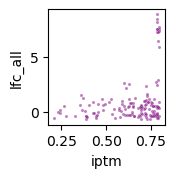

0.24909456740442654 141


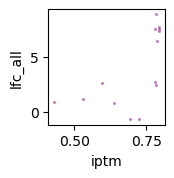

0.7010989010989012


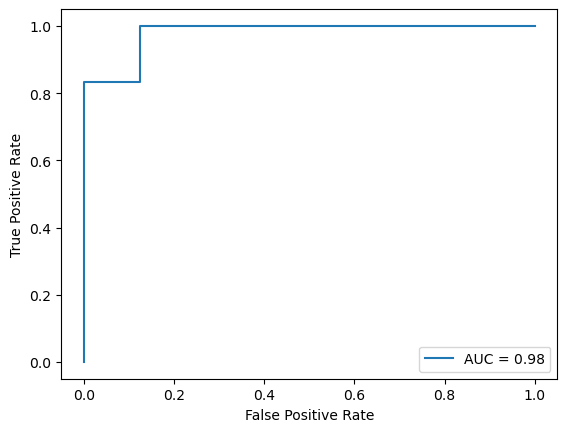

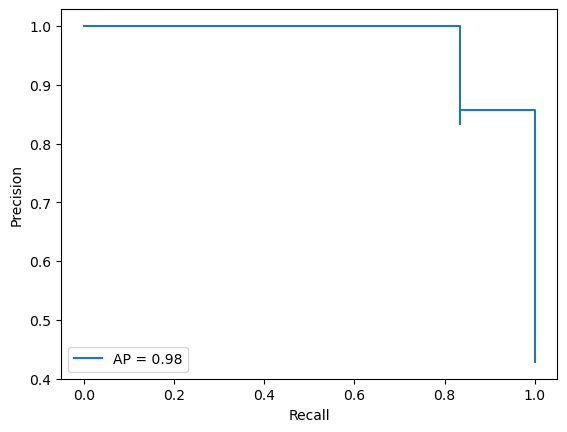

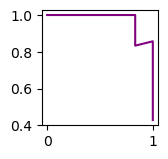

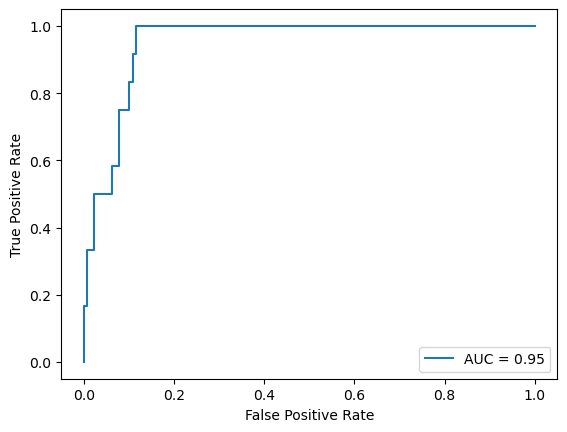

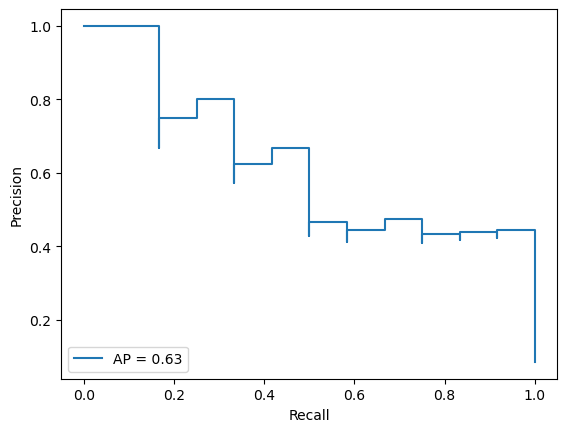

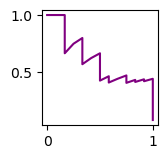

In [9]:
#iPTM
# ncip and malb modeling info 
v2_inputs, cols_not_model = load_dataset_single('v2', 'af', 'ncip')
#v2_malbs, cols_not_model_malbs = load_dataset_single('v3', 'af', 'ncip')

labels = v2_inputs[['ppi', 'order_padj_sets']].drop_duplicates()
v2_inputs = v2_inputs.groupby(['ppi']).mean()
v2_inputs = v2_inputs.merge(labels, on = 'ppi')
to_correl['ppi'] = to_correl['PPI']
#v2_inputs = v2_inputs.merge(to_correl[['ppi', 'order_padj_sets']], on = 'ppi')

#n = 141
fig, axes = plt.subplots(1, sharex = False)
sns.scatterplot(data = v2_inputs, x = 'iptm', y = 'lfc_all', alpha = 0.5, color = 'purple', s= 5)
fig.set_size_inches(1.5,1.5)
plt.savefig('icipa_correl_lfc.svg')
plt.show()
sr_test = spearmanr(v2_inputs['lfc_all'], v2_inputs['iptm'])[0]
pr_test = pearsonr(v2_inputs['lfc_all'], v2_inputs['iptm'])[0]**2
print (sr_test, v2_inputs.shape[0])
#just the test set (results in fig 6)
#n = 14
fig, axes = plt.subplots(1, sharex = False)
sns.scatterplot(data = v2_inputs[v2_inputs['order_padj_sets'] == 'test'], x = 'iptm', y = 'lfc_all', alpha = 0.5, color = 'purple', s= 5)
fig.set_size_inches(1.5,1.5)
plt.savefig('icipa_correl_lfc_test.svg')
plt.show()
sr_test = spearmanr(v2_inputs[v2_inputs['order_padj_sets'] == 'test']['lfc_all'], 
                    v2_inputs[v2_inputs['order_padj_sets'] == 'test']['iptm'])[0]
pr_test = pearsonr(v2_inputs[v2_inputs['order_padj_sets'] == 'test']['lfc_all'], 
                   v2_inputs[v2_inputs['order_padj_sets'] == 'test']['iptm'])[0]**2
print (sr_test)
df_reg_bar.loc[df_reg_bar.shape[0]] = ['1iptm', sr_test]

#AUC curves 
fpr, tpr, thresholds = sklearn.metrics.roc_curve(v2_inputs[v2_inputs['order_padj_sets'] == 'test']['binned'],
                                                  v2_inputs[v2_inputs['order_padj_sets'] == 'test']['iptm'])
aucroc = sklearn.metrics.roc_auc_score(v2_inputs[v2_inputs['order_padj_sets'] == 'test']['binned'],
                                                  v2_inputs[v2_inputs['order_padj_sets'] == 'test']['iptm'])
roc_display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = aucroc).plot()

prec, rec, thresholds = sklearn.metrics.precision_recall_curve(v2_inputs[v2_inputs['order_padj_sets'] == 'test']['binned'],
                                                  v2_inputs[v2_inputs['order_padj_sets'] == 'test']['iptm'])
avg_pr = sklearn.metrics.average_precision_score(v2_inputs[v2_inputs['order_padj_sets'] == 'test']['binned'],
                                                  v2_inputs[v2_inputs['order_padj_sets'] == 'test']['iptm'])
roc_display = sklearn.metrics.PrecisionRecallDisplay(precision=prec, recall=rec, average_precision= avg_pr).plot()
fig, axes = plt.subplots(1, sharex = False)
plt.plot(rec, prec, color = 'purple')
fig.set_size_inches(1.5,1.5)
plt.savefig('iptm_prec_rec_ncip_test.svg')
plt.show()
df_class_bar.loc[df_class_bar.shape[0]] = ['1iptm', avg_pr]

#AUC curves 
fpr, tpr, thresholds = sklearn.metrics.roc_curve(v2_inputs['binned'],
                                                  v2_inputs['iptm'])
aucroc = sklearn.metrics.roc_auc_score(v2_inputs['binned'],
                                                  v2_inputs['iptm'])
roc_display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = aucroc).plot()

prec, rec, thresholds = sklearn.metrics.precision_recall_curve(v2_inputs['binned'],
                                                  v2_inputs['iptm'])
avg_pr = sklearn.metrics.average_precision_score(v2_inputs['binned'],
                                                  v2_inputs['iptm'])
roc_display = sklearn.metrics.PrecisionRecallDisplay(precision=prec, recall=rec, average_precision= avg_pr).plot()

fig, axes = plt.subplots(1, sharex = False)
plt.plot(rec, prec, color = 'purple')
fig.set_size_inches(1.5,1.5)
plt.savefig('iptm_prec_rec_ncip_all.svg')
plt.show()


train    127
test      14
Name: order_padj_sets, dtype: int64
train    127
test      14
Name: order_padj_sets, dtype: int64
best l1:     dataset r2_cutoff  l2_penalty  train_r2_not_avgd  train_r2  \
16      v2        T0        10.0           0.355409  0.505141   

    train_spearman_not_avgd  train_spearman  test_r2_not_avgd  test_r2  \
16                 0.248275        0.274056          0.738989  0.84858   

    test_spearman_not_avgd  test_spearman  n_non_zero  
16                0.817525       0.863736          35   10.0


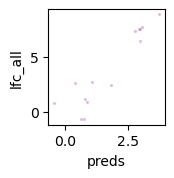

0.8637362637362638


In [17]:
#LFC predictor test performance for ncip v2 (largest predictor)
#iPTM
# ncip and malb modeling info 
v2_inputs, cols_not_model = load_dataset_single('v2', 'T0', 'ncip')

get_trained_model_v3_t1, x_scaler, y_scaler, list_cols = padj_get_model_regression('v2', 'T0',  'ncip', '07_23_ncip_regression_default.csv', False, False)
test_input = v2_inputs[list_cols].to_numpy()
x_test_scaled = x_scaler.transform(test_input)
preds = get_trained_model_v3_t1.predict(x_test_scaled)
preds = y_scaler.inverse_transform(preds)
v2_inputs['preds'] = preds
avgs_test = v2_inputs[v2_inputs.order_padj_sets == 'test'].groupby(['ppi']).mean()

fig, axes = plt.subplots(1, sharex = False)
sns.scatterplot(data = avgs_test, x = 'preds', y = 'lfc_all', alpha = 0.25, color = 'purple', s= 5)
fig.set_size_inches(1.5,1.5)
plt.savefig('model_test_perf_ncip.svg')
plt.show()

sr_test = spearmanr(avgs_test['lfc_all'], avgs_test['preds'])[0]
pr_test = pearsonr(avgs_test['lfc_all'], avgs_test['preds'])[0]**2
print (sr_test)

df_reg_bar.loc[df_reg_bar.shape[0]] = ['model', sr_test]

train    127
test      14
Name: order_padj_sets, dtype: int64
train    127
test      14
Name: order_padj_sets, dtype: int64
best l1:     dataset r2_cutoff  l2_penalty  rocauc_train_not_avgd  rocauc_train  \
16      v2        T0    0.063096                    1.0           1.0   

    avgpr_train_not_avgd  avgpr_train  rocauc_test_not_avgd  rocauc_test  \
16                   1.0          1.0                   1.0          1.0   

    avgpr_test_not_avgd  avgpr_test  n_non_zero  
16                  1.0         1.0          35   0.0630957344480193
14


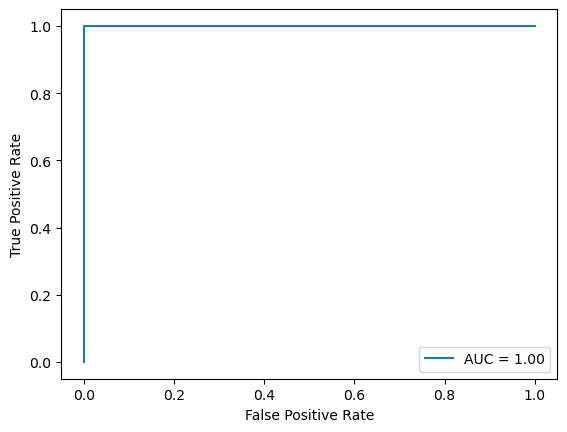

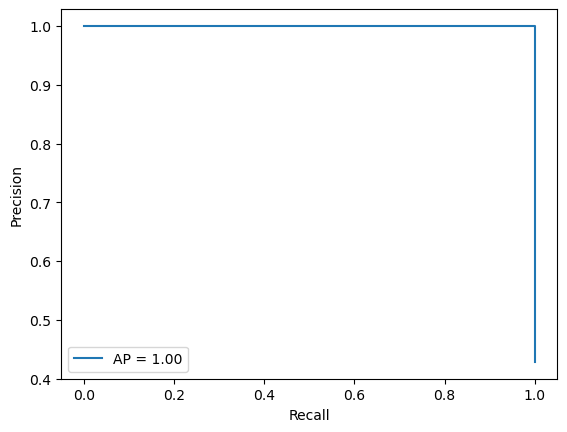

In [7]:
#LFC predictor test performance for ncip v2 (largest predictor)
#iPTM
# ncip and malb modeling info 
v2_inputs, cols_not_model = load_dataset_single('v2', 'T0', 'ncip')

get_trained_model_v3_t1, x_scaler, list_cols = padj_get_model_classif('v2', 'T0',  'ncip', '07_23_ncip_classification_default.csv', False, False)
test_input = v2_inputs[list_cols].to_numpy()
x_test_scaled = x_scaler.transform(test_input)
preds = get_trained_model_v3_t1.predict_proba(x_test_scaled)[:,1]
v2_inputs['preds'] = preds
avgs_test = v2_inputs[v2_inputs.order_padj_sets == 'test'].groupby(['ppi']).mean()

#AUC curves 
fpr, tpr, thresholds = sklearn.metrics.roc_curve(avgs_test['binned'],
                                                  avgs_test['preds'])
aucroc = sklearn.metrics.roc_auc_score(avgs_test['binned'],
                                                  avgs_test['preds'])
roc_display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = aucroc).plot()

prec, rec, thresholds = sklearn.metrics.precision_recall_curve(avgs_test['binned'],
                                                  avgs_test['preds'])
avg_pr = sklearn.metrics.average_precision_score(avgs_test['binned'],
                                                  avgs_test['preds'])
roc_display = sklearn.metrics.PrecisionRecallDisplay(precision=prec, recall=rec, average_precision= avg_pr).plot()
print (avgs_test.shape[0])

df_class_bar.loc[df_class_bar.shape[0]] = ['model', avg_pr]

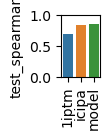

In [9]:
plot_regression(df_reg_bar.sort_values(by = 'dataset'), savename = 'test.svg', w = 0.5, h = 0.8)

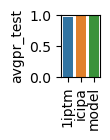

In [10]:
plot_classif(df_class_bar.sort_values(by = 'dataset'), savename = 'test2.svg', w = 0.5, h = 0.8)

train    430
test      47
Name: order_padj_sets, dtype: int64


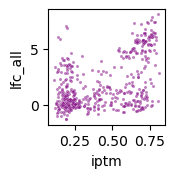

0.4223940810535448 0.2455433125717843 477


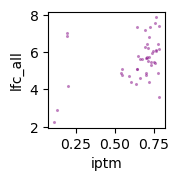

0.3831251548259119


In [20]:
#iptm for malbs 
#iPTM
# ncip and malb modeling info 
v2_inputs, cols_not_model = load_dataset_single('malb_v2', 'af', 'malb')
test_train_split = ['test', 'train'] * int((0.1 * mp3_seq_values.shape[0]))
test_train_split = test_train_split + ['train'] * int(mp3_seq_values.shape[0] - len(test_train_split))
mp3_seq_values = mp3_seq_values.sort_values('ashr_padj_HIS_TRP')
mp3_seq_values['order_padj_sets'] = test_train_split
#v2_malbs, cols_not_model_malbs = load_dataset_single('v3', 'af', 'ncip')

labels = v2_inputs[['ppi', 'order_padj_sets']].drop_duplicates()
v2_inputs = v2_inputs.groupby(['ppi']).mean()
v2_inputs = v2_inputs.merge(labels, on = 'ppi')
to_correl['ppi'] = to_correl['PPI']
#v2_inputs = v2_inputs.merge(to_correl[['ppi', 'order_padj_sets']], on = 'ppi')

#n = 141
fig, axes = plt.subplots(1, sharex = False)
sns.scatterplot(data = v2_inputs, x = 'iptm', y = 'lfc_all', alpha = 0.5, color = 'purple', s= 5)
fig.set_size_inches(1.5,1.5)
plt.savefig('icipa_correl_lfc.svg')
plt.show()
sr_test = spearmanr(v2_inputs['lfc_all'], v2_inputs['iptm'])[0]
pr_test = pearsonr(v2_inputs['lfc_all'], v2_inputs['iptm'])[0]**2
print (sr_test, pr_test, v2_inputs.shape[0])
#just the test set (results in fig 6)
#n = 14
fig, axes = plt.subplots(1, sharex = False)
sns.scatterplot(data = v2_inputs[v2_inputs['order_padj_sets'] == 'test'], x = 'iptm', y = 'lfc_all', alpha = 0.5, color = 'purple', s= 5)
fig.set_size_inches(1.5,1.5)
plt.savefig('icipa_correl_lfc_test.svg')
plt.show()
sr_test = spearmanr(v2_inputs[v2_inputs['order_padj_sets'] == 'test']['lfc_all'], 
                    v2_inputs[v2_inputs['order_padj_sets'] == 'test']['iptm'])[0]
pr_test = pearsonr(v2_inputs[v2_inputs['order_padj_sets'] == 'test']['lfc_all'], 
                   v2_inputs[v2_inputs['order_padj_sets'] == 'test']['iptm'])[0]**2
print (sr_test)
df_reg_bar_malb.loc[df_reg_bar_malb.shape[0]] = ['iptm', sr_test]

train    430
test      47
Name: order_padj_sets, dtype: int64
train    430
test      47
Name: order_padj_sets, dtype: int64
best l1:     dataset r2_cutoff  l2_penalty  train_r2_not_avgd  train_r2  \
9  malb_v3        T0   63.095734           0.276402  0.344445   

   train_spearman_not_avgd  train_spearman  test_r2_not_avgd   test_r2  \
9                 0.433575        0.482823          0.153316  0.195221   

   test_spearman_not_avgd  test_spearman  n_non_zero  
9                0.332277       0.419403          39   63.09573444801943


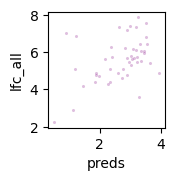

0.4194033302497687 47


In [19]:
#LFC predictor test performance for ncip v2 (largest predictor)
#iPTM
# ncip and malb modeling info 
v2_inputs, cols_not_model = load_dataset_single('malb_v3', 'T0', 'malb')

get_trained_model_v3_t1, x_scaler, y_scaler, list_cols = padj_get_model_regression('malb_v3', 'T0',  'malb', '07_23_malb_regression_default.csv', False, False)
test_input = v2_inputs[list_cols].to_numpy()
x_test_scaled = x_scaler.transform(test_input)
preds = get_trained_model_v3_t1.predict(x_test_scaled)
preds = y_scaler.inverse_transform(preds)
v2_inputs['preds'] = preds
avgs_test = v2_inputs[v2_inputs.order_padj_sets == 'test'].groupby(['ppi']).mean()

fig, axes = plt.subplots(1, sharex = False)
sns.scatterplot(data = avgs_test, x = 'preds', y = 'lfc_all', alpha = 0.25, color = 'purple', s= 5)
fig.set_size_inches(1.5,1.5)
plt.savefig('model_malbs.svg')
plt.show()

sr_test = spearmanr(avgs_test['lfc_all'], avgs_test['preds'])[0]
pr_test = pearsonr(avgs_test['lfc_all'], avgs_test['preds'])[0]**2
print (sr_test, avgs_test.shape[0])
df_reg_bar_malb.loc[df_reg_bar_malb.shape[0]] = ['model', sr_test]

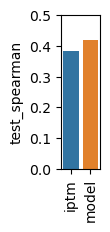

In [14]:
plot_regression(df_reg_bar_malb.sort_values(by = 'dataset'), savename = 'test3.svg', w = 0.5, h = 2, lim = 0.5)

In [ ]:
with open('myfile.txt', 'r+') as f:
    djalfdjf;